In [307]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

import seaborn as sns
import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats

In [308]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

### Load data from MC approximation of permutation test

In [309]:
def loadMcResult(sampleShape, mean):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv("dataFastPerm/data_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv("dataFastPerm/data_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv("dataFastPerm/data_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv("dataFastPerm/data_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [101]:
def run_test(X,Y,bins, parallel=True, midP=False):

    
    
    if parallel:
        #Exact test
        SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
        SGM.run(X.reshape(1,-1),Y.reshape(1,-1), midP)
        p_val = SGM.p_values[0]
    else:
        p_val = p_value_calc([list(X), list(Y), bins])

    return p_val

### Get all p-values from the prallelized exact test from the same data as the MC version

In [102]:
def shiftMethod(X_list, y_list, bins, parallel=True, midP=False):
    pt_list = list()
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_t = list()
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            #p_t.append(ttest_ind(y, x)[1] / 2)
            
            t, p = ttest_ind(y, x)
            p = p/2
            if t<0:
                p = 1-p
       
            p_t.append(p)
        
            start = time.time()
            p_e.append(run_test(y, x, bins, parallel, midP))
            end = time.time()
        
            time_list.append(end - start)
    
        pt_list.append(p_t)
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pt_list, pe_list, TIME
    

### Compare parallelized and MC version

In [103]:
def compare(p_val_list, pe_list, pt_list):
    PE_err = list()
    PAE_err = list()
    
    for P_ae, P_e, P_t in zip(p_val_list, pe_list, pt_list):
        P_ae_error = list()
        P_e_error = list()
        
        for ae, e, t in zip(P_ae, P_e, P_t):
            P_ae_error.append((ae - t) / t)
            P_e_error.append((e - t) / t)
            
        PE_err.append(P_e_error)
        PAE_err.append(P_ae_error)
    
    return PE_err, PAE_err


### Boxplot

In [104]:
def boxPlot(error, Bin, log=False, path=None):
    my_dict = dict()
    for d, b in zip(error, Bin):
        my_dict[str(b)] = d
    
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    
    plt.ylabel(r"$\frac{p_{e}-p_{t}}{p_{t}}$",fontsize=20)
        
        
    plt.xlabel("Sample size",fontsize=15)
    
    #if MAX and MIN:
    #    RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
    #    ax.set_yticks(RANGE)
    #    ax.set_yticklabels(10.0**RANGE)
    if log:
        RANGE = np.arange(np.floor(np.min(error)), np.ceil(np.max(error)))
        ax.set_yticks(RANGE)
        ax.set_yticklabels(10.0**RANGE)

    
    if path:
        fig.savefig(path+".jpg", bbox_inches='tight')
        
    

### Time-plot

In [370]:
def preparePandas(timeData, sampleSizes, test="Parallelization of shift method"):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        for t in time:
        
            preparePd.append([str(test),t, sample])
    return preparePd
    
    

In [371]:
def timePlotSNS(TIMEParallel, TIME_MC, sampleShape, log=False, TIMEsingleThred=False, path=None):

    
    preparePdParallel = preparePandas(TIMEParallel, sampleShape)
    preparePdMc = preparePandas(TIME_MC, sampleShape, 'Fast approximation method')
    
    if np.any(TIMEsingleThred):
        preparePdSingle = preparePandas(TIMEsingleThred, sampleShape, 'Single thread shift method')
        data = preparePdMc + preparePdParallel + preparePdSingle
    else:
        data = preparePdMc + preparePdParallel
        
    pdData = pd.DataFrame(data, columns=['method', 'time(s)','bins'])
    
    if log:        
        MAX = max(np.max(TIMEParallel), np.max(TIME_MC))
        MIN = min(np.min(TIMEParallel), np.min(TIME_MC))
        if np.any(TIMEsingleThred):
            MAX = max(np.max(TIMEParallel), np.max(TIME_MC), np.max(TIMEsingleThred))
            MIN = min(np.min(TIMEParallel), np.min(TIME_MC), np.min(TIMEsingleThred))
            
    
        snsPlot = sns.lineplot(x="bins", y="time(s)",
             hue="method",
             data=pdData)#.set(yticks = RANGE, yticklabels=10**RANGE)
        plt.yticks(RANGE, 10.0**RANGE)
        
        
    else:
        snsPlot = sns.lineplot(x="bins", y="time(s)",
             hue="method",
             data=pdData)
        print(snsPlot)
    
    if path:
        
        fig = snsPlot.get_figure()
        print(fig)

        fig.savefig(path)



In [372]:
def timePlot(TIMEParallel, TIME_MC, sampleShape, path=None, log=False, TIMEsingleThred=None):
    plt.plot(sampleShape, np.mean(TIMEParallel,axis=1), 'r-', label='Parallelization of P-value')
    plt.plot(sampleShape, np.mean(TIME_MC,axis=1), 'g-', label='Approximation of P-value')
    if np.any(TIMEsingleThred):
        plt.plot(sampleShape, np.mean(TIMEsingleThred,axis=1), 'y-', label='Single thread shift method of P-value')
        
    plt.legend(loc='upper left')
    plt.xlabel(r"Sample size")
    if log:        
        MAX = max(np.max(TIMEParallel), np.max(TIME_MC))
        MIN = min(np.min(TIMEParallel), np.min(TIME_MC))
        if np.any(TIMEsingleThred):
            MAX = max(np.max(TIMEParallel), np.max(TIME_MC), np.max(TIMEsingleThred))
            MIN = min(np.min(TIMEParallel), np.min(TIME_MC), np.min(TIMEsingleThred))
            
        
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        plt.yticks(RANGE, 10.0**RANGE)
            
    plt.ylabel("Time(s)")
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

In [373]:
def getPATH(path, suffix, prefix):
    return path + '/'+ suffix + '/' + prefix

In [374]:
path = "figures/paralellVsFastApprox"

## Sample sizes of X and Y

In [375]:
sampleShape = [10,50,100,150,200,250,300]

# Experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [376]:
mean = 5.2

In [377]:
X_list5_2, y_list5_2, p_val_list5_2, time_listMc5_2 = loadMcResult(sampleShape, mean)

In [378]:
pt_list5_2, pe_list5_2, TIME5_2 = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40)

# Runtime comparison

In [379]:
TIMEParallel5_2 = np.asarray([np.array(T) for T in TIME5_2])
TIME_MC5_2 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_2])

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


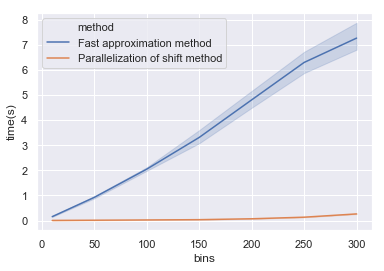

In [380]:
timePlotSNS(TIMEParallel5_2, TIME_MC5_2, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

Figure(432x288)


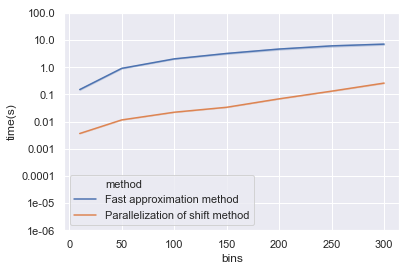

In [381]:
timePlotSNS(np.log10(TIMEParallel5_2), np.log10(TIME_MC5_2), sampleShape, 
                    path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [382]:
mean = 5.4

In [383]:
X_list5_4, y_list5_4, p_val_list5_4, time_listMc5_4 = loadMcResult(sampleShape, mean)
pt_list5_4, pe_list5_4, TIME5_4 = shiftMethod(np.asarray(X_list5_4), np.asarray(y_list5_4), 40)
PE_err5_4, PAE_err5_4 = compare(p_val_list5_4, pe_list5_4, pt_list5_4)

In [384]:
pt_list5_4midP, pe_list5_4midP, TIME5_4midP = shiftMethod(np.asarray(X_list5_4), np.asarray(y_list5_4), 40, midP=True)
PE_err5_4midP, PAE_err5_4midP = compare(p_val_list5_4, pe_list5_4midP, pt_list5_4midP)

# Runtime comparison

In [385]:
TIMEParallel5_4 = np.asarray([np.array(T) for T in TIME5_4])
TIME_MC5_4 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_4])


AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


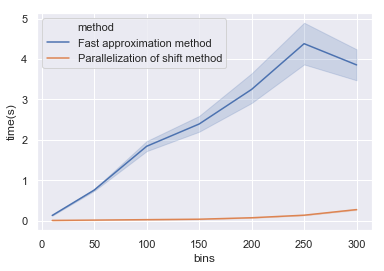

In [386]:
timePlotSNS(TIMEParallel5_4, TIME_MC5_4, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

Figure(432x288)


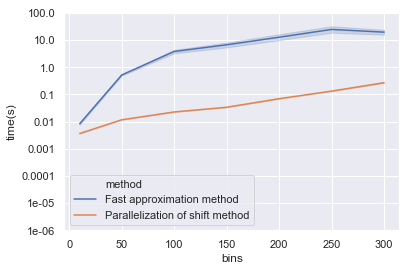

In [387]:
timePlotSNS(np.log10(TIMEParallel5_4), np.log(TIME_MC5_4), sampleShape, path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [388]:
mean=5.6

In [389]:
X_list5_6, y_list5_6, p_val_list5_6, time_listMc5_6 = loadMcResult(sampleShape, mean)
pt_list5_6, pe_list5_6, TIME5_6 = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40)
PE_err5_6, PAE_err5_6 = compare(p_val_list5_6, pe_list5_6, pt_list5_6)

In [390]:
pt_list5_6midP, pe_list5_6midP, TIME5_6midP = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40, midP=True)
PE_err5_6midP, PAE_err5_6midP = compare(p_val_list5_6, pe_list5_6midP, pt_list5_6midP)

# Runtime comparison

In [391]:
TIMEParallel5_6 = np.asarray([np.array(T) for T in TIME5_6])
TIME_MC5_6 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_6])


AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


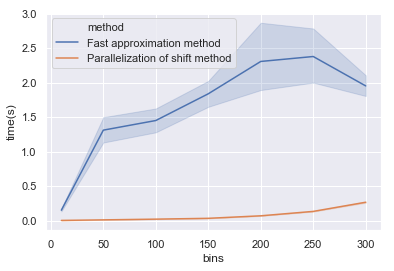

In [392]:
timePlotSNS(TIMEParallel5_6, TIME_MC5_6, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

Figure(432x288)


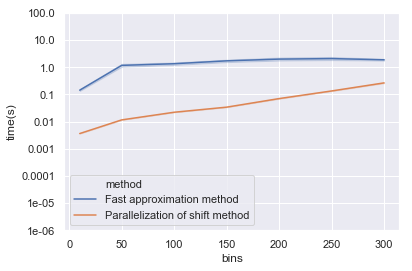

In [393]:
timePlotSNS(np.log10(TIMEParallel5_6), np.log10(TIME_MC5_6), sampleShape, path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [394]:
mean=5.8

In [395]:
X_list5_8, y_list5_8, p_val_list5_8, time_listMc5_8 = loadMcResult(sampleShape, mean)
pt_list5_8, pe_list5_8, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40)
PE_err5_8, PAE_err5_8 = compare(p_val_list5_8, pe_list5_8, pt_list5_8)

In [396]:
pt_list5_8midP, pe_list5_8midP, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40, midP=True)
PE_err5_8midP, PAE_err5_8midP = compare(p_val_list5_8, pe_list5_8midP, pt_list5_8midP)

# Runtime comparison

In [397]:
TIMEParallel5_8 = np.asarray([np.array(T) for T in TIME5_8])
TIME_MC5_8 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_8])

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


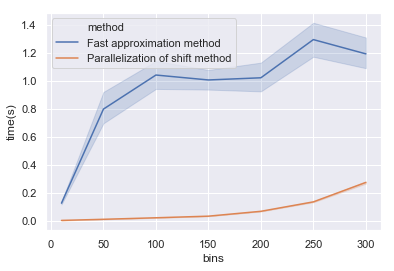

In [398]:
timePlotSNS(TIMEParallel5_8, TIME_MC5_8, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

Figure(432x288)


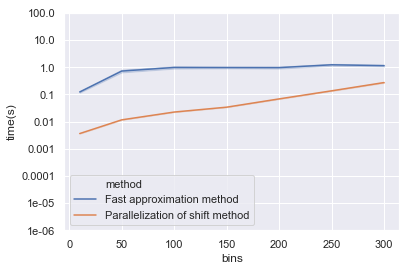

In [399]:
timePlotSNS(np.log10(TIMEParallel5_8), np.log10(TIME_MC5_8), sampleShape, path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [400]:
mean=6.0

In [401]:
X_list6_0, y_list6_0, p_val_list6_0, time_listMc6_0 = loadMcResult(sampleShape, int(mean))
pt_list6_0, pe_list6_0, TIME6_0 = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40)
PE_err6_0, PAE_err6_0 = compare(p_val_list6_0, pe_list6_0, pt_list6_0)

In [402]:
pt_list6_0midP, pe_list6_0midP, TIME6_0midP = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40, midP=True)
PE_err6_0midP, PAE_err6_0midP = compare(p_val_list6_0, pe_list6_0midP, pt_list6_0midP)

# Runtime comparison

In [403]:
TIMEParallel6_0 = np.asarray([np.array(T) for T in TIME6_0])
TIME_MC6_0 = np.asarray([np.array(Tmc) for Tmc in time_listMc6_0])

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


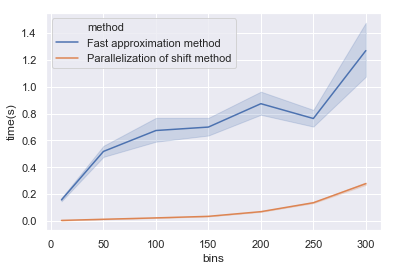

In [404]:
timePlotSNS(TIMEParallel6_0, TIME_MC6_0, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

Figure(432x288)


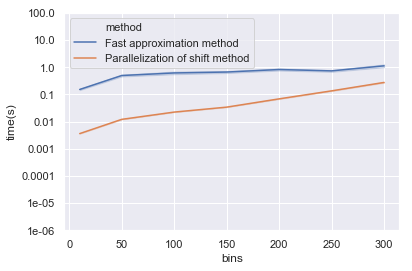

In [405]:
timePlotSNS(np.log10(TIMEParallel6_0), np.log10(TIME_MC6_0), sampleShape, 
            path=getPATH(path, str(mean),"SNSruntimeLog"),log=True)

# Timeseries comparison with shiftMethod single thread

In [140]:
singleT_pt_list6_0, singleT_pe_list6_0, singleT_TIME6_0 = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40, False)

### Ensure that the single thread and parallelized version yield the same p-values

In [141]:
for st_l, para_l in zip(singleT_pt_list6_0,pt_list6_0):
    st_a = np.array(st_l)
    para_a = np.array(para_l)
    print(np.allclose(st_a, para_a))

True
True
True
True
True
True
True


### Recall that the runtime for the shift method will be invaraint between all these experiemnts since all hyperparameter is constant (only different types of data).

In [142]:
parallel_TIME, singleThreadTime = TIMEParallel6_0, singleT_TIME6_0

# Runtime for experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [417]:
mean = 5.2

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


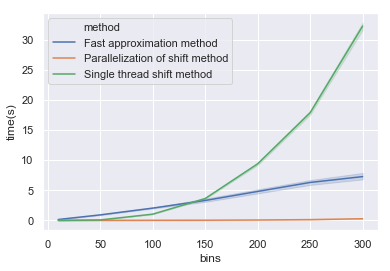

In [418]:
timePlotSNS(parallel_TIME, TIME_MC5_2, sampleShape, 
            path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=False, 
            TIMEsingleThred=singleThreadTime)




Figure(432x288)


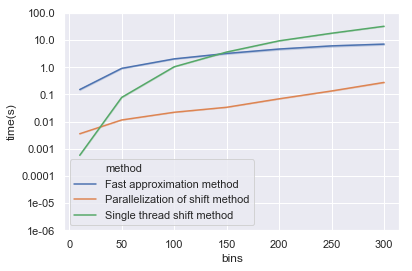

In [419]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_2), 
            sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=True, 
            TIMEsingleThred=np.log10(singleThreadTime))

# Runtime for experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [420]:
mean = 5.4

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


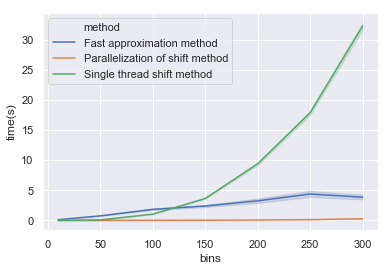

In [421]:
timePlotSNS(parallel_TIME, TIME_MC5_4, sampleShape, 
         path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=False, TIMEsingleThred=singleThreadTime)


Figure(432x288)


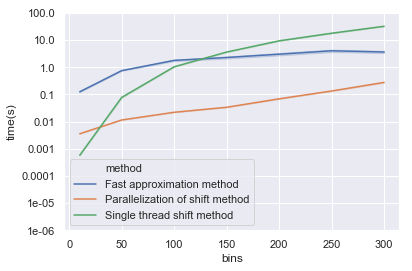

In [422]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_4), 
            sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
            log=True, TIMEsingleThred=np.log10(singleThreadTime))


# Runtime for experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [423]:
mean = 5.6

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


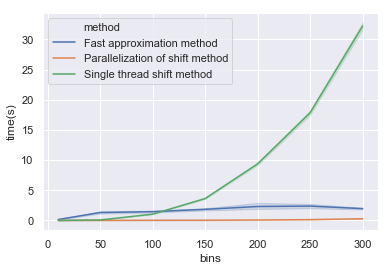

In [424]:
timePlotSNS(parallel_TIME, TIME_MC5_6, sampleShape, 
         path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=False, 
         TIMEsingleThred=singleThreadTime)

Figure(432x288)


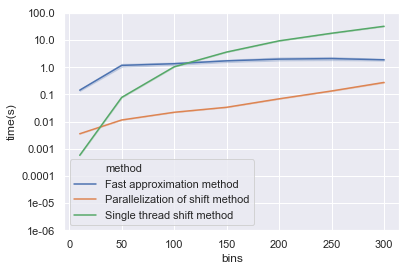

In [425]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_6), 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=True, 
         TIMEsingleThred=np.log10(singleThreadTime))


# Runtime for experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [426]:
mean = 5.8

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


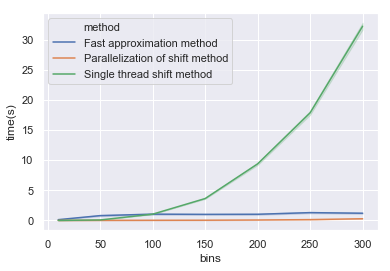

In [427]:
timePlotSNS(parallel_TIME, TIME_MC5_8, 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=False, TIMEsingleThred=singleThreadTime)


Figure(432x288)


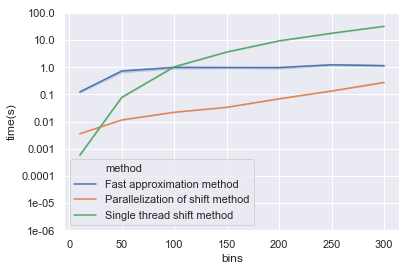

In [428]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_8), 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=True, TIMEsingleThred=np.log10(singleThreadTime))


# Runtime for experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [429]:
mean = 6.0

AxesSubplot(0.125,0.125;0.775x0.755)
Figure(432x288)


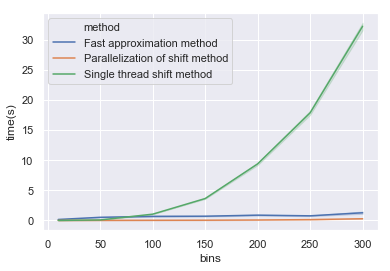

In [430]:
timePlotSNS(parallel_TIME, TIME_MC6_0, 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=False, TIMEsingleThred=singleThreadTime)

Figure(432x288)


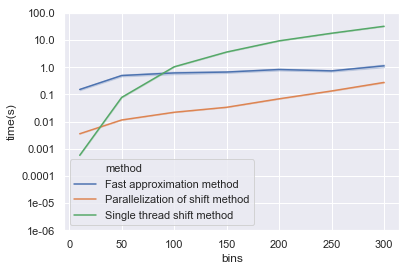

In [431]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC6_0), sampleShape, 
         path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=True, TIMEsingleThred=np.log10(singleThreadTime))